# Group Proposal

#### **Authors:** Linda Huang, Manav Kakar, Omer Tahir, Yuchen Zhang
#### **Group:** 2

## Introduction

1. **Relevant background information** on the topic so that someone unfamiliar with it will be prepared to understand the rest of your proposal.

2. **Clearly state the question** you will try to answer with your project. Your question should involve one random variable of interest (the response) and one or more explanatory variables. Of the response variable, explain whether your project is focused on prediction, inference, or both.

3. **Identify and describe the dataset** that will be used to answer the question. Remember, this dataset is allowed to contain more variables than you need, in fact, exploring how the different variables in the dataset affect your model, is a crucial part of the project.

4. Also, be sure to **frame your question/objectives in terms of what is already known in the literature**. Be sure to include at least **two scientific publications** that can help frame your study (you will need to include these in the References section).

## Preliminary Results

In [22]:
library(tidyverse)
library(broom)
library(repr)
library(digest)
library(infer)
library(gridExtra)
library(faraway)
library(mltools)
library(leaps)
library(glmnet)
library(cowplot)

options(repr.matrix.max.rows = 6) #limits output of dataframes to 6 rows


Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine



Attaching package: ‘mltools’


The following object is masked from ‘package:tidyr’:

    replace_na


Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


Loaded glmnet 4.1-2



In [5]:
url <- "http://archive.ics.uci.edu/ml/machine-learning-databases/00560/SeoulBikeData.csv"

bike_data <- 
#read.csv("data/SeoulBikeData.csv") |>
    read.csv(url, encoding = 'utf-8') |>
    setNames(c("date",
               "bike_count",
               "hour",
               "temperature",
               "humidity",
               "wind_speed",
               "visibility",
               "dew_point_temp",
               "radiation",
               "rain",
               "snow",
               "season",
               "holiday",
               "functional_day")) |>
    filter(functional_day == "Yes") |>
    select(-functional_day) 

In [6]:
View(head(bike_data))

,date,bike_count,hour,temperature,humidity,wind_speed,visibility,dew_point_temp,radiation,rain,snow,season,holiday
,<chr>,<int>,<int>,<dbl>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
1,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0,0,0,Winter,No Holiday
2,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0,0,0,Winter,No Holiday
3,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0,0,0,Winter,No Holiday
4,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0,0,0,Winter,No Holiday
5,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0,0,0,Winter,No Holiday
6,01/12/2017,100,5,-6.4,37,1.5,2000,-18.7,0,0,0,Winter,No Holiday


### Correlation plot

In [54]:
options(repr.plot.width = 15, repr.plot.height = 10)

corr_plot <- 
    bike_data |>
    select(-c(date, season, holiday, bike_count)) |>
    cor() |>
    round(2) |> 
    ggcorrplot(hc.order = TRUE,
               outline.col = "white",
               type = "lower",
               lab = TRUE,
               lab_size = 6,
               tl.cex = 18,
               colors = c("white", "orange", "red"),
               legend.title = "Correlation Coefficient\n") +
    theme(legend.title = element_text(size = 18, face = "bold"),
          legend.text = element_text(size = 18),
          legend.key.size = unit(2, "cm")) 

corr_plot

ERROR: Error in ggcorrplot(round(cor(select(bike_data, -c(date, season, holiday, : could not find function "ggcorrplot"


In general, an absolute correlation coefficient of >0.7 among two or more predictors indicates the presence of multicollinearity.

From the correlation plot we can see there are some potential confounders, for example, temperature and dew_point_temp, visibility, dew_point_temp, radiation and humidity. 

In [55]:
VIF_MLR_bike <- 
    bike_data %>%
    select(-c(date, season, holiday)) %>%
    lm(bike_count ~ ., data = .) %>%
    vif() %>%
    round(3)

VIF_MLR_bike

hour    temperature       humidity     wind_speed     visibility 
         1.180         87.644         20.163          1.274          1.575 
dew_point_temp      radiation           rain           snow 
       116.462          2.011          1.084          1.096

James et al. (2013) in [*An Introduction to Statistical Learning*](https://www.statlearning.com/) (see Section 3.3.3 in Subsection Collinearity) indicate that, as a rule of thumb, a VIF value that exceeds 5 or 10 is an indicator of a  multicollinearity problem. 

In [56]:
VIF_MLR_bike <- 
    bike_data %>%
    select(-c(date, season, holiday, dew_point_temp)) %>%
    lm(bike_count ~ ., data = .) %>%
    vif() %>%
    round(3)

VIF_MLR_bike

hour temperature    humidity  wind_speed  visibility   radiation 
      1.178       1.629       2.533       1.272       1.564       1.911 
       rain        snow 
      1.071       1.091

#### Relation b/w high correlated variables and response variable

In [57]:
bike_data_1 <- bike_data %>%
              select(- date)%>%
              group_by(hour) %>%
              summarise(mean_bike_count= mean(bike_count))
head(bike_data_1)


hour,mean_bike_count
<int>,<dbl>
0,561.4574
1,441.9233
2,312.7699
3,210.8409
4,137.4886
5,144.2188


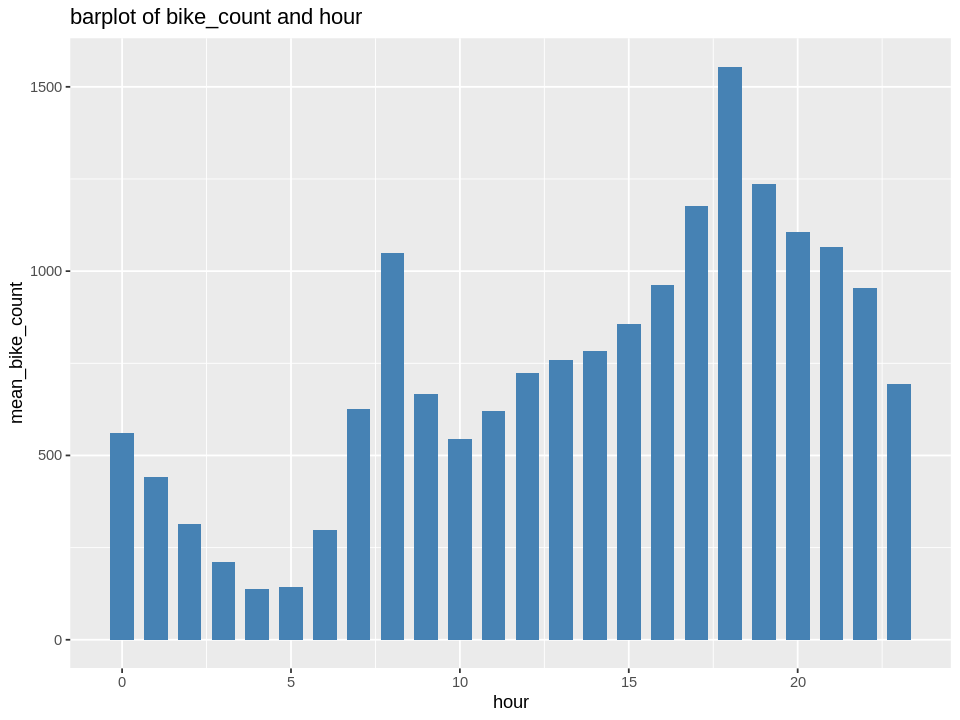

In [58]:
options(repr.plot.width = 8, repr.plot.height = 6)
bike_data_1_plot <- bike_data_1 %>%
   ggplot(aes(x=hour, y= mean_bike_count)) +
   geom_bar(stat="identity",width=0.7, fill="steelblue")+  
   ggtitle("barplot of bike_count and hour")
bike_data_1_plot


In [59]:
options(repr.plot.width = 8, repr.plot.height = 6)
bike_data_2 <- bike_data %>%
              select(- date)%>%
              group_by(temperature) %>%
              summarise(mean_bike_count= mean(bike_count))
head(bike_data_2)

temperature,mean_bike_count
<dbl>,<dbl>
-17.8,322.0
-17.5,145.5
-17.4,64.0
-16.9,36.0
-16.5,96.0
-16.4,186.5


`geom_smooth()` using formula 'y ~ x'



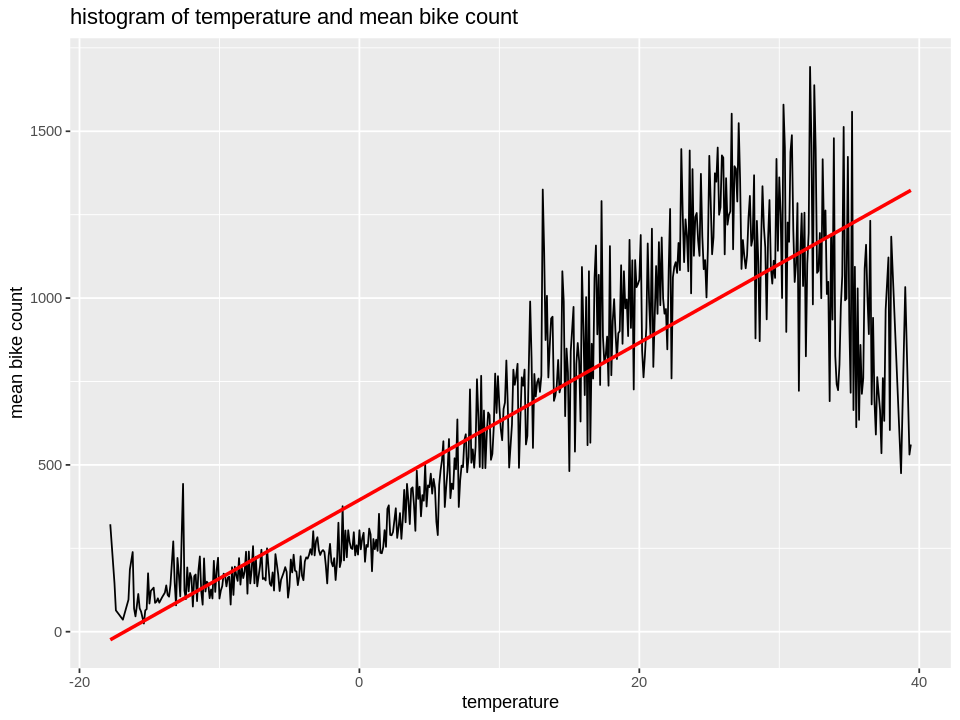

In [60]:
options(repr.plot.width = 8, repr.plot.height = 6)
bike_plot_2 <- 
     ggplot(bike_data_2, aes(x=temperature,y=mean_bike_count))+
     geom_line()+
     geom_smooth(method=lm , color="red", se=FALSE) +
     labs(x ="temperature", y="mean bike count")+
     ggtitle("histogram of temperature and mean bike count")
 
bike_plot_2

In [61]:
options(repr.plot.width = 8, repr.plot.height = 6)
bike_data_3 <- bike_data %>%
              select(- date)%>%
              group_by(season) %>%
              summarise(mean_bike_count= mean(bike_count))
head(bike_data_3)

season,mean_bike_count
<chr>,<dbl>
Autumn,924.1105
Spring,746.2542
Summer,1034.0734
Winter,225.5412


`From the above two plots, we can see that the bike count
varies greatly with temperature and hour, as we can see from the correlation plot.`

### building generative model

In [39]:
bike_data_4 <- bike_data %>%
         select(- c(date,dew_point_temp))

MLR_generative <- lm(bike_count~.,bike_data_4)

MLR_generative_result <- tidy(MLR_generative) %>% mutate_if(is.numeric, round, 2)
MLR_generative_result
nrow(MLR_generative_result)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),603.97,45.20,13.36,0
hour,28.69,0.75,38.23,0
temperature,27.18,0.88,30.77,0
⋮,⋮,⋮,⋮,⋮
seasonSummer,-160.46,17.38,-9.23,0
seasonWinter,-362.48,19.97,-18.15,0
holidayNo Holiday,120.36,22.35,5.39,0


[1] 13

In [63]:
bike_forward <- regsubsets(
  x=bike_count ~ ., 
  nvmax=12,
  data=bike_data_4,
  method="forward",
)
bike_forward

bike_forward_summary <- summary(bike_forward)

bike_forward_summary_df <- tibble(
   n_input_variables = 1:12,
   RSQ = bike_forward_summary$rsq,
   RSS = bike_forward_summary$rss,
   ADJ.R2 = bike_forward_summary$adjr2
)

Subset selection object
Call: regsubsets.formula(x = bike_count ~ ., nvmax = 12, data = bike_data_4, 
    method = "forward", )
12 Variables  (and intercept)
                  Forced in Forced out
hour                  FALSE      FALSE
temperature           FALSE      FALSE
humidity              FALSE      FALSE
wind_speed            FALSE      FALSE
visibility            FALSE      FALSE
radiation             FALSE      FALSE
rain                  FALSE      FALSE
snow                  FALSE      FALSE
seasonSpring          FALSE      FALSE
seasonSummer          FALSE      FALSE
seasonWinter          FALSE      FALSE
holidayNo Holiday     FALSE      FALSE
1 subsets of each size up to 12
Selection Algorithm: forward

In [64]:
bike_forward_summary
bike_forward_summary_df


Subset selection object
Call: regsubsets.formula(x = bike_count ~ ., nvmax = 12, data = bike_data_4, 
    method = "forward", )
12 Variables  (and intercept)
                  Forced in Forced out
hour                  FALSE      FALSE
temperature           FALSE      FALSE
humidity              FALSE      FALSE
wind_speed            FALSE      FALSE
visibility            FALSE      FALSE
radiation             FALSE      FALSE
rain                  FALSE      FALSE
snow                  FALSE      FALSE
seasonSpring          FALSE      FALSE
seasonSummer          FALSE      FALSE
seasonWinter          FALSE      FALSE
holidayNo Holiday     FALSE      FALSE
1 subsets of each size up to 12
Selection Algorithm: forward
          hour temperature humidity wind_speed visibility radiation rain snow
1  ( 1 )  " "  "*"         " "      " "        " "        " "       " "  " " 
2  ( 1 )  "*"  "*"         " "      " "        " "        " "       " "  " " 
3  ( 1 )  "*"  "*"         "*"      " " 

n_input_variables,RSQ,RSS,ADJ.R2
<int>,<dbl>,<dbl>,<dbl>
1,0.3166765,2386420903,0.3165958
2,0.4454842,1936576319,0.4453531
3,0.4909530,1777782394,0.4907725
⋮,⋮,⋮,⋮
10,0.5410271,1602904957,0.5404842
11,0.5414985,1601258438,0.5409019
12,0.5415509,1601075444,0.5409000


## Methods: Plan

## References